In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


In [509]:
main_2020 = pd.read_csv('main_2020_all.csv')
print(main_2020.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            18408 non-null  int64  
 1   quarter                         18408 non-null  object 
 2   monthsigned                     18408 non-null  float64
 3   market                          18408 non-null  object 
 4   region                          18408 non-null  object 
 5   city                            18408 non-null  object 
 6   state                           18408 non-null  object 
 7   internal_submarket              18408 non-null  object 
 8   internal_class                  18408 non-null  object 
 9   leasedSF                        18408 non-null  float64
 10  internal_industry               18408 non-null  object 
 11  transaction_type                18408 non-null  object 
 12  space_type                      

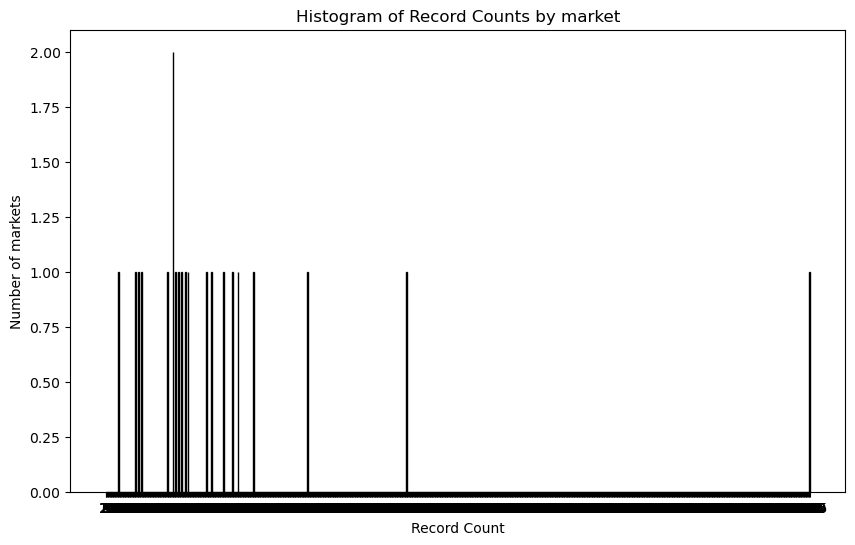

In [510]:
city_counts = main_2020.groupby('market').size().reset_index(name='record_count')

# Define bins with an interval of 10. 
bins = np.arange(0, city_counts['record_count'].max() + 10, 5)

# Create the histogram.
plt.figure(figsize=(10, 6))
plt.hist(city_counts['record_count'], bins=bins, edgecolor='black')
plt.title('Histogram of Record Counts by market')
plt.xlabel('Record Count')
plt.ylabel('Number of markets')
plt.xticks(bins)  # Optional: Set x-ticks to show bin edges
plt.show()

In [511]:
main_2020['quarter_encoded'] = main_2020['quarter'].replace({
    'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4
})

/tmp/ipykernel_1775/3549346842.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  main_2020['quarter_encoded'] = main_2020['quarter'].replace({


In [ ]:
features_for_clustering = [
    "quarter", "market", "internal_submarket", "internal_class", "leasedSF", "state",
    "internal_industry", "transaction_type", "space_type", "CBD_suburban", "RBA",
    "availability_proportion", "internal_class_rent", "overall_rent",
    "direct_availability_proportion", "direct_overall_rent", "sublet_available_space", "leasing"
]

# Identify which columns are categorical vs. numeric.
# You might want to treat columns with values like "Q1", "Atlanta", etc. as categorical.
categorical_columns = [
    "quarter", "market", "internal_submarket", "internal_class", "state",
    "internal_industry", "transaction_type", "space_type", "CBD_suburban"
]
numeric_columns = [
    "leasedSF", "RBA", "availability_proportion", "internal_class_rent", "overall_rent",
    "direct_availability_proportion", "direct_overall_rent", "sublet_available_space", "leasing"
]

# Drop rows with missing values in the selected features.
clustering_df = main_2020.dropna(subset=features_for_clustering).copy()

# Create a ColumnTransformer to encode categorical columns and scale numeric columns.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), numeric_columns)
    ]
)

# Apply the transformations to get the final numeric feature matrix for clustering.
X_cluster = preprocessor.fit_transform(clustering_df[features_for_clustering])

# X_cluster is now a numeric array that you can use with your clustering algorithm (e.g., KMeans).
print("Transformed feature matrix shape:", X_cluster.shape)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_df['cluster'] = kmeans.fit_predict(X_cluster)

# -------------------------------
# Merge the cluster labels back into the main_2020 DataFrame.
# This assumes that the index in clustering_df aligns with main_2020.
main_2020 = main_2020.merge(clustering_df[['cluster']], left_index=True, right_index=True, how='left')

# -------------------------------
# Group by 'market' to generate a market value score.

# 1. Count how many records in each market fall into each cluster.
market_cluster_counts = main_2020.groupby('market')['cluster'].value_counts().unstack(fill_value=0)

# 2. Convert the counts to percentages for each market.
market_cluster_pct = market_cluster_counts.div(market_cluster_counts.sum(axis=1), axis=0) * 100

# 3. Define weights for clusters.
# Here we assume a higher cluster number indicates a better market.
cluster_weights = {0: 1, 1: 4, 2: 9}

# 4. Define a function to compute the weighted market score.
def compute_market_score(row, weights):
    # Multiply the percentage for each cluster by its weight and sum the result.
    return sum(row[cluster] * weights[cluster] for cluster in row.index)

# 5. Apply the function to compute a score for each market.
market_scores = market_cluster_pct.apply(lambda row: compute_market_score(row, cluster_weights), axis=1)
market_scores = market_scores.reset_index(name='market_value_score')

# -------------------------------
# Export the market scores to CSV and display the result.
market_scores.to_csv("market_value_score_by_market.csv", index=False)
print(market_scores.head())


Transformed feature matrix shape: (18408, 360)
      market  market_value_score
0    Atlanta          274.298056
1     Austin          196.226415
2  Baltimore          100.000000
3     Boston          158.064516
4  Charlotte          148.387097


Ranked variables influencing categorical target:
                           Feature  Importance
9                         leasedSF    0.211527
7               internal_submarket    0.123114
10                transaction_type    0.098682
2                      monthsigned    0.097802
5                             city    0.056006
11                      space_type    0.040486
20      direct_internal_class_rent    0.027085
16             internal_class_rent    0.024663
24      sublet_internal_class_rent    0.024449
26                         leasing    0.023581
17                    overall_rent    0.022970
21             direct_overall_rent    0.022513
25             sublet_overall_rent    0.022267
22          sublet_available_space    0.021862
13                             RBA    0.020515
18          direct_available_space    0.020490
23  sublet_availability_proportion    0.020310
15         availability_proportion    0.020166
14                 available_space    0.020009
19  direct_

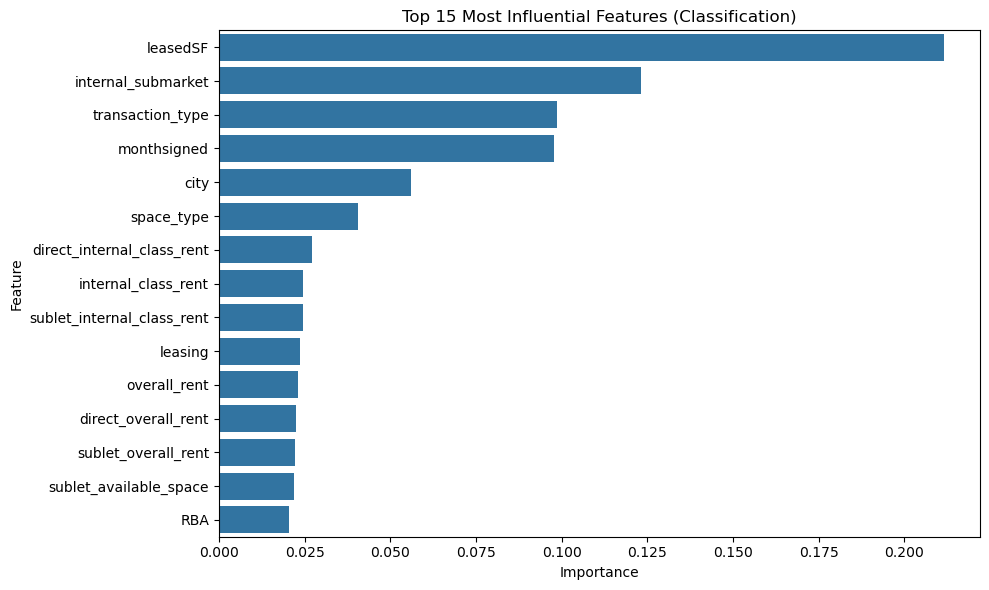

In [513]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = main_2020.copy()

# --- Set your categorical target ---
target = "internal_industry"  # Change to your actual column
X = df.drop(columns=[target])
y = df[target]

# Encode categorical features in X
for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Encode y (if needed)
if y.dtype == 'object' or y.dtype.name == 'category':
    y = LabelEncoder().fit_transform(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Output results
print("Ranked variables influencing categorical target:")
print(importance_df)

# Optional plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Most Influential Features (Classification)")
plt.tight_layout()
plt.show()

In [514]:
us_cities = pd.read_csv("uscities.csv")

main_2020_cy = main_2020
main_2020_cy = main_2020.merge(
    us_cities[['city', 'state_id', 'county_name']],   # pick the columns you need
    left_on=['city', 'state'],                        # columns in main_2020
    right_on=['city', 'state_id'],                    # columns in us_cities
    how='left'
)

# Optionally, rename 'county_name' to just 'county'
main_2020_cy.rename(columns={'county_name': 'county'}, inplace=True)

# Check results
print(main_2020_cy[['city', 'state', 'county']].drop_duplicates().head(10))
main_2020_cy = main_2020_cy[main_2020_cy['county'].isin(main_2020_cy['county'].value_counts()[lambda x: x >= 3].index)]
main_2020_cy.info()


             city state     county
0        Norcross    GA   Gwinnett
2          Duluth    GA   Gwinnett
4         Atlanta    GA     Fulton
8   Sandy Springs    GA     Fulton
16         Austin    TX     Travis
22   Windsor Mill    MD        NaN
24      Cambridge    MA  Middlesex
26     Burlington    MA        NaN
28         Canton    MA        NaN
30         Boston    MA    Suffolk
<class 'pandas.core.frame.DataFrame'>
Index: 17512 entries, 0 to 18407
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            17512 non-null  int64  
 1   quarter                         17512 non-null  object 
 2   monthsigned                     17512 non-null  float64
 3   market                          17512 non-null  object 
 4   region                          17512 non-null  object 
 5   city                            17512 non-null  object 
 6   state             

In [518]:
# Reset indices if needed.
main_2020_cy = main_2020_cy.reset_index(drop=True)

# Define clustering_df_cy by copying main_2020_cy
clustering_df_cy = main_2020_cy.copy()

# -------------------------------
# Define features for clustering.
features_for_clustering = [
    "quarter", "internal_class", "leasedSF", "state",
    "internal_industry", "transaction_type", "space_type", "CBD_suburban", "RBA",
    "availability_proportion", "overall_rent",
    "direct_availability_proportion", "direct_overall_rent", "sublet_available_space", "leasing"
]

# Identify which columns are categorical vs. numeric.
categorical_columns = [
    "quarter", "internal_class", "state", "internal_industry", "transaction_type", "space_type", "CBD_suburban"
]
numeric_columns = [
    "leasedSF", "RBA", "availability_proportion", "overall_rent",
    "direct_availability_proportion", "direct_overall_rent", "sublet_available_space", "leasing"
]

# -------------------------------
# Drop rows with missing values in the selected features from clustering_df_cy.
clustering_df_cy = clustering_df_cy.dropna(subset=features_for_clustering).copy()

# Create a ColumnTransformer to encode categorical columns and scale numeric columns.
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), numeric_columns)
    ]
)

# Apply the transformations to get the final numeric feature matrix for clustering.
X_cluster = preprocessor.fit_transform(clustering_df_cy[features_for_clustering])
print("Transformed feature matrix shape:", X_cluster.shape)

# -------------------------------
# Clustering with KMeans:
from sklearn.cluster import KMeans
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clustering_df_cy['cluster'] = kmeans.fit_predict(X_cluster)

# -------------------------------
# Merge the cluster labels from clustering_df_cy into main_2020_cy.
main_2020_cy = main_2020_cy.merge(clustering_df_cy[['cluster']], left_index=True, right_index=True, how='left')

# -------------------------------
# Group by 'county' to generate a county value score.
# 1. Count how many records in each county fall into each cluster.
county_cluster_counts = main_2020_cy.groupby('county')['cluster'].value_counts().unstack(fill_value=0)

# 2. Convert the counts to percentages for each county.
county_cluster_pct = county_cluster_counts.div(county_cluster_counts.sum(axis=1), axis=0) * 100

# 3. Define weights for clusters.
# (Here we assume that a higher cluster number indicates a better market.)
cluster_weights = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}

# 4. Define a function to compute the weighted county score.
def compute_county_score(row, weights):
    return sum(row[cluster] * weights[cluster] for cluster in row.index)

# 5. Apply the function to compute a score for each county.
county_scores = county_cluster_pct.apply(lambda row: compute_county_score(row, cluster_weights), axis=1)
county_scores = county_scores.reset_index(name='county_value_score')

# -------------------------------
# Export the county scores to CSV and display the first few rows.
county_scores.to_csv("county_value_score.csv", index=False)
print(county_scores.head())


Transformed feature matrix shape: (17512, 68)
         county  county_value_score
0    Alexandria          520.588235
1  Anne Arundel          243.478261
2     Arlington          546.020761
3     Baltimore          180.357143
4        Bergen          316.666667
